## ISIC 2024 - Skin Cancer Detection with 3D-TBP
### OverView
In this challenge you are differentiating benign from malignant cases. For each image (isic_id) you are assigning the probability (target) ranging [0, 1] that the case is malignant.
### Dataset
* train-image/ - image files for the training set (provided for train only)
* train-image.hdf5 - training image data contained in a single hdf5 file, with the isic_id as key
* train-metadata.csv - metadata for the training set
* test-image.hdf5 - test image data contained in a single hdf5 file, with the isic_id as key. This contains 3 test examples to ensure your inference pipeline works correctly. When the submitted notebook is rerun, this file is swapped with the full hidden test set, which contains approximately 500k images.
* test-metadata.csv - metadata for the test subset
* sample_submission.csv - a sample submission file in the correct format



### Stratigy 
* Balance the data first
* First CNN would be simple
* Second CNN would be using Transfer Learning using VGG16 or Res-Net
* 3rd would be using Cap-Net

### Importing Libraries 🗃️

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
    
from PIL import Image

import tensorflow as tf

### Data Analysis and Visulization 🔬

Reading the Files

In [2]:
train_csv_File = pd.read_csv('train-metadata.csv')
train_csv_File.head()

C:\Users\M_ros\AppData\Local\Temp\ipykernel_25820\1241744407.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv_File = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
train_csv_File.shape
## so in train we have 55 columns and 401059 rows

(401059, 55)

In [4]:
train_csv_File.columns.to_list()

['isic_id',
 'target',
 'patient_id',
 'age_approx',
 'sex',
 'anatom_site_general',
 'clin_size_long_diam_mm',
 'image_type',
 'tbp_tile_type',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_C',
 'tbp_lv_Cext',
 'tbp_lv_H',
 'tbp_lv_Hext',
 'tbp_lv_L',
 'tbp_lv_Lext',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaA',
 'tbp_lv_deltaB',
 'tbp_lv_deltaL',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_eccentricity',
 'tbp_lv_location',
 'tbp_lv_location_simple',
 'tbp_lv_minorAxisMM',
 'tbp_lv_nevi_confidence',
 'tbp_lv_norm_border',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_stdL',
 'tbp_lv_stdLExt',
 'tbp_lv_symm_2axis',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_x',
 'tbp_lv_y',
 'tbp_lv_z',
 'attribution',
 'copyright_license',
 'lesion_id',
 'iddx_full',
 'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence']

In [5]:
print("No of Target in the Dataset  ")
train_csv_File['target'].value_counts()

No of Target in the Dataset  


target
0    400666
1       393
Name: count, dtype: int64

## Plotting Image 📈

In [6]:
images_dir = os.listdir('train-image/image')
print("No of images we have -->",len(images_dir))

No of images we have --> 401059


In [7]:
# taking 8 random positive and negative image
pos_img_file = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 1]['isic_id']),8) 
print('Postive Image ID-->',pos_img_file)


neg_img_file = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 0]['isic_id']),8) 
print('Negative Image ID-->',neg_img_file)

Postive Image ID--> ['ISIC_1805261', 'ISIC_3266736', 'ISIC_6608075', 'ISIC_2090244', 'ISIC_8966407', 'ISIC_9140699', 'ISIC_4384129', 'ISIC_6294286']
Negative Image ID--> ['ISIC_4783485', 'ISIC_9025617', 'ISIC_4456732', 'ISIC_4896640', 'ISIC_2837129', 'ISIC_5863158', 'ISIC_2632859', 'ISIC_5930066']


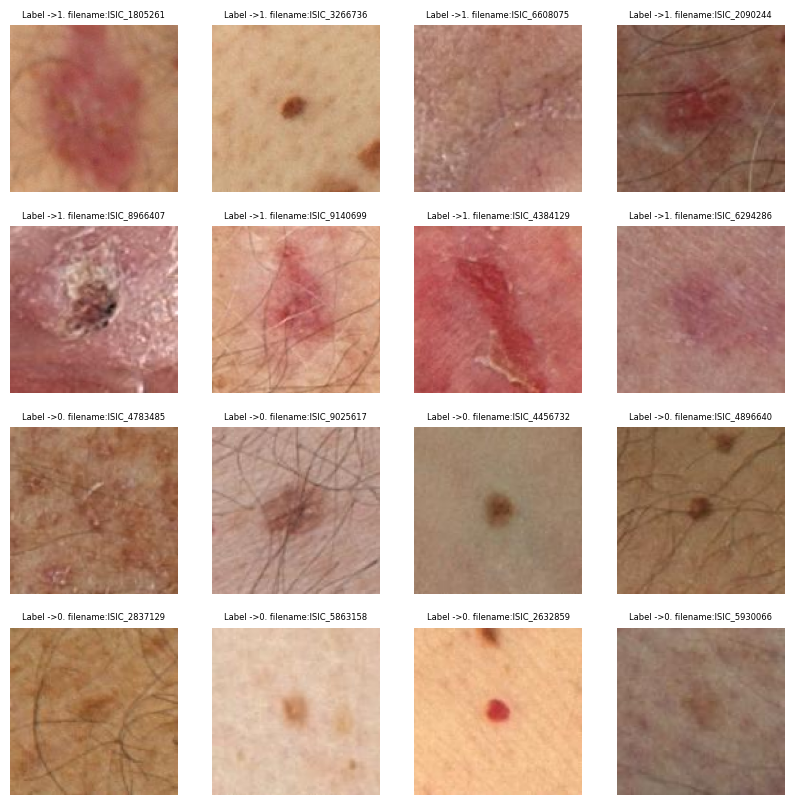

In [8]:
fig , axs = plt.subplots(nrows=4,ncols=4,figsize = (10,10))

for ax , im , target in zip(axs.flatten(),pos_img_file+neg_img_file,[1]*8+[0]*8):
    img = Image.open('train-image/image/'+f'{im}.jpg')
    ax.imshow(img)
    ax.axis('off')

    ax.set_title(f'Label ->{target}. filename:{im}',fontsize= 6)


## Balacning the dataset ⚖️
I am going to select random negative 391 images from dataset and 391 positive images and store them in lists

In [9]:
images_paths = [] # list to store image_paths
images_labels = [] # list to store labels


pos_img_pahts = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 1]['isic_id']),391)
neg_img_paths = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 0]['isic_id']),391)


In [10]:
len(pos_img_pahts)

391

Now storing the labels

In [11]:
pol = []
negl = []
for i , k in zip(neg_img_paths,pos_img_pahts):
    pol.append(train_csv_File.loc[train_csv_File['isic_id'] == k]['target'].values[0])
    negl.append(train_csv_File.loc[train_csv_File['isic_id'] == i]['target'].values[0])


Storing them into main images and labels lists

In [12]:
images_paths = pos_img_pahts + neg_img_paths
images_labels = pol + negl

In [13]:
len(images_paths)
len(images_labels)

782

In [32]:
tf.io.read_file(os.path.join('train-image/image/', f'{images_paths[0]}.jpg'))

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00}\x00}\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\

tf.io.read_file(os.path.join('train-image/image/', f'{images_paths[0]}.jpg'))

## Data Pre-Processing 📡

In [177]:
def load_and_preprocess_image(im_path, label):
    im_path = tf.strings.join(['train-image/image/', im_path, '.jpg'], separator='')
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((images_paths, images_labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images_paths), seed=42)

# Define the split ratio
validation_split = 0.2
dataset_size = len(images_paths)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)


In [178]:
len(train_dataset)

626

In [179]:
len(validation_dataset)

156

In [180]:
# Map the preprocessing function to both datasets
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the datasets
batch_size = 5
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [181]:
len(train_dataset)

126

In [182]:
len(train_dataset)

126

## Building CNN Model 🧠 

In [184]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

In [185]:
model = Sequential([
    Conv2D(32,(3,3),activation = 'relu',input_shape = (64,64,3)),
    Conv2D(64,(3,3),activation = 'relu'),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(1,activation = 'sigmoid')
       
])

In [186]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 flatten_10 (Flatten)        (None, 230400)            0         
                                                                 
 dense_20 (Dense)            (None, 128)               29491328  
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 29,510,849
Trainable params: 29,510,849
Non-trainable params: 0
_________________________________________________________________


### Compiling the model

In [187]:
model.compile(optimizer='adam',loss= 'binary_crossentropy',metrics=['accuracy'])

## Fitting the Model

In [188]:
jistory = model.fit(train_dataset,
          validation_data= validation_dataset,
          epochs = 70,
          validation_steps = 10 )

Epoch 1/70
126/126 [==============================] - 2s 12ms/step - loss: 0.8767 - accuracy: 0.4776 - val_loss: 0.7272 - val_accuracy: 0.4600
Epoch 2/70
126/126 [==============================] - 1s 10ms/step - loss: 0.6964 - accuracy: 0.5559 - val_loss: 0.6890 - val_accuracy: 0.5800
Epoch 3/70
126/126 [==============================] - 1s 10ms/step - loss: 0.6977 - accuracy: 0.5351 - val_loss: 0.6830 - val_accuracy: 0.5800
Epoch 4/70
126/126 [==============================] - 1s 10ms/step - loss: 0.7138 - accuracy: 0.5655 - val_loss: 0.6819 - val_accuracy: 0.5600
Epoch 5/70
126/126 [==============================] - 1s 10ms/step - loss: 0.7029 - accuracy: 0.5383 - val_loss: 1.2541 - val_accuracy: 0.4800
Epoch 6/70
126/126 [==============================] - 1s 10ms/step - loss: 0.7036 - accuracy: 0.5623 - val_loss: 0.6883 - val_accuracy: 0.5600
Epoch 7/70
126/126 [==============================] - 1s 10ms/step - loss: 0.6823 - accuracy: 0.5335 - val_loss: 0.6520 - val_accuracy: 0.6200

In [97]:
model.save("SimpleCNN_70.h5")

## Graph Validation

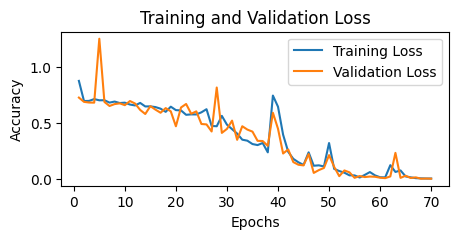

In [189]:

# Extract accuracy and validation accuracy
accuracy = jistory.history['loss']
val_accuracy = jistory.history['val_loss']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 2))
plt.plot(epochs, accuracy, label='Training Loss')
plt.plot(epochs, val_accuracy, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


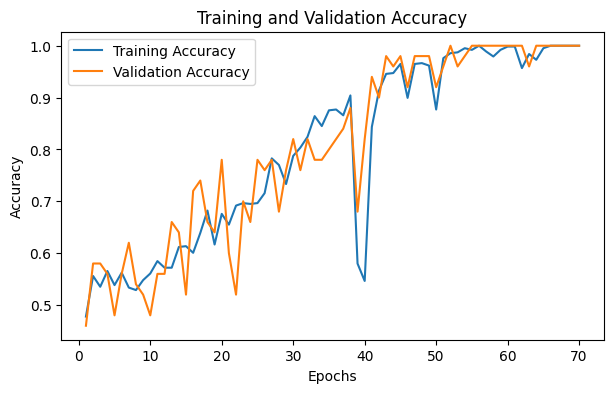

In [190]:
# Extract accuracy and validation accuracy
accuracy = jistory.history['accuracy']
val_accuracy = jistory.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Testing on Custom Image

In [145]:
from tensorflow.keras.models import load_model
# Define the function to load and preprocess the custom image
def load_and_preprocess_custom_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

# Path to the custom image
custom_image_path = 'test_images\ISIC_0015740.jpg'

# Load and preprocess the custom image
cmodel = load_model('SimpleCNN_70.h5')
custom_image = load_and_preprocess_custom_image(custom_image_path)
custom_image = tf.expand_dims(custom_image, axis=0)  # Add batch dimension

# Predict using the trained model
prediction = cmodel.predict(custom_image)

# Print the prediction
print("Prediction for the custom image:", prediction)



1/1 [==============================] - 0s 47ms/step
Prediction for the custom image: [[1.3484465e-13]]


In [192]:
import gradio as gr

c:\Users\M_ros\anaconda3\envs\tf3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [199]:
from PIL import Image
import cv2

In [212]:
def predict_the_skin_Cancer(image):
    img_array = np.array(image)
    # Resize the image using OpenCV
    img_resized = cv2.resize(img_array,(64,64))
    # Normalize the image
    img_resized = img_resized.astype('float32') / 255.0
    # Expand dimensions to match the input shape for the model
    img_resized = np.expand_dims(img_resized, axis=0)
   
   
   
    cmodel = load_model('SimpleCNN_70.h5')
    prediction = cmodel.predict(img_resized)
    prediction = prediction[0][0]

    
    
    if prediction > 0.5:
        result = f"Prediction: Malignant (Probability: {prediction:.6f})"
    else:
        result = f"Prediction: Benign (Probability: {prediction:.6f})"
    
    return result


    return prediction[0]

# Create the Gradio interface
iface = gr.Interface(
    fn= predict_the_skin_Cancer,
    inputs=gr.Image(type="pil",label='Upload the Image'),
    outputs= gr.Textbox(label='Prediction'),
    title="Skin Cancer Detection ",
    description="Upload an Image of Skin and get prediction either there are chances of Cancer or Not."
)
iface.launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.12.0, however version 4.29.0 is available, please upgrade.
--------
1/1 [==============================] - 0s 49ms/step


In [208]:
if 1.5931451e-14 > 0:
    print('ues')

ues


ROC curve

1/1 [==============================] - 0s 21ms/step
Length of y_true: 156
Length of y_scores: 156


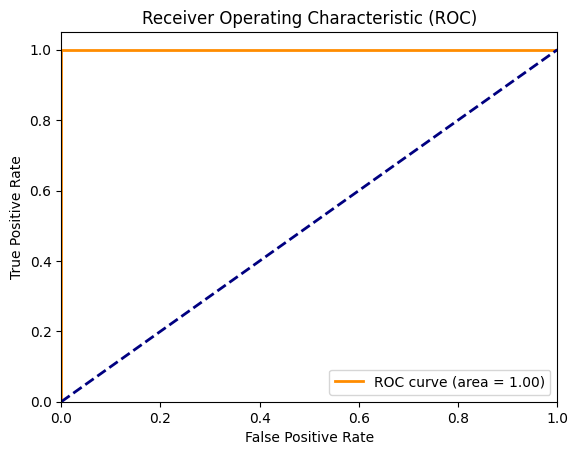

In [191]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists for true labels and predicted scores
y_true = []
y_scores = []

# Iterate over the validation dataset
for images, labels in validation_dataset:
    # Predict probabilities
    predictions = cmodel.predict(images)
    
    # Flatten predictions to 1D array
    predictions = predictions.flatten()
    
    # Convert predictions to binary (optional, for confusion matrix or other metrics)
    binary_predictions = (predictions > 0.5).astype(int)
    
    # Extend y_true and y_scores lists
    y_true.extend(labels.numpy())
    y_scores.extend(predictions)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Print the lengths of y_true and y_scores for debugging
print("Length of y_true:", len(y_true))
print("Length of y_scores:", len(y_scores))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## Making Submission File

Reading test files form hdf5 passing them to model and getting prediction 

In [224]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io  # Import io module for BytesIO

cmodel = load_model('SimpleCNN_70.h5')
image_ids = []
predictions = []

# Load the HDF5 file
file_path = 'test-image.hdf5'  # Replace with your HDF5 file path
with h5py.File(file_path, 'r') as hdf:
    # Access each dataset and display or process the data
    for key in hdf.keys():
        print(key)
        # Load binary data
        binary_data = hdf[key][...]
        image_ids.append(key)
        # Convert binary data to image
        image = Image.open(io.BytesIO(binary_data))
        image = np.array(image)  # Convert PIL Image to numpy array
        img_resized = cv2.resize(image,(64,64))
        img_resized = img_resized.astype('float32') / 255.0
        img_resized = np.expand_dims(img_resized, axis=0)
    
    
        prediction = cmodel.predict(img_resized)
        if prediction[0][0] > 0.5:
            predictions.append(f'{prediction[0][0]:.6f}')
        else:
            predictions.append(f'{prediction[0][0]:.6f}')
    

ISIC_0015657
1/1 [==============================] - 0s 65ms/step
ISIC_0015729
1/1 [==============================] - 0s 14ms/step
ISIC_0015740
1/1 [==============================] - 0s 20ms/step


['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']

In [226]:
import pandas as pd
submission_data = pd.DataFrame({'isic_id':image_ids,'target':predictions})
submission_data

,isic_id,target
0,ISIC_0015657,0.499541
1,ISIC_0015729,0.090995
2,ISIC_0015740,0.000000


In [227]:
submission_data.to_csv("MySubmission.csv")

## END